IMPORTAMOS LIBRERIAS

In [1]:
import pandas as pd
import numpy as np

LEEMOS LOS DATASETS

In [ ]:
dim_player = pd.read_csv("dim_player.csv", sep=";")
dim_injury_category = pd.read_csv("dim_injury_category.csv")
fact_combine = pd.read_csv("fact_combine.csv")
fact_injuries = pd.read_csv("fact_injuries.csv")
fact_player_stats = pd.read_csv("fact_player_stats.csv", low_memory=False)  

LIMPIEZA DE LOS DATOS

In [5]:
print("===DIM_PLAYER===")
print(dim_player.info())
print(dim_player.isna().sum)

print("===DIM_INJURY_CATEGORY===")
print(dim_injury_category.info())
print(dim_injury_category.isna().sum)

print("===FACT_COMBINE===")
print(fact_combine.info())
print(fact_combine.isna().sum)

print("===FACT_INJURIES===")
print(fact_injuries.info())
print(fact_injuries.isna().sum)

print("===FACT_PLAYER_STATS===")
print(fact_player_stats.info())
print(fact_player_stats.isna().sum)


===DIM_PLAYER===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4171 entries, 0 to 4170
Data columns (total 17 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   player_id           4171 non-null   int64  
 1   player_name         4171 non-null   object 
 2   position            4171 non-null   object 
 3   birthdate           4171 non-null   object 
 4   country             4171 non-null   object 
 5   school              4162 non-null   object 
 6   from_year           4156 non-null   float64
 7   to_year             4156 non-null   float64
 8   age_at_debut        4139 non-null   float64
 9   age_at_last_season  4153 non-null   float64
 10  height_m            4075 non-null   object 
 11  weight_kg           4071 non-null   object 
 12  BMI                 4071 non-null   object 
 13  body_fat_pct_est    4070 non-null   object 
 14  fat_mass_kg         4070 non-null   object 
 15  lean_mass_kg        4070 non-null   ob

NORMALIZAMOS NUMEROS CON UNA FUNCION GENERAL

In [21]:
# Mostrar prolijo en el notebook (solo visual, no modifica datos)
pd.set_option("display.precision", 2)
pd.set_option("display.float_format", "{:.2f}".format)

def to_float(s):
    return (
        s.astype(str)
         .str.replace(",", ".", regex=False)
         .str.replace("%", "", regex=False)
         .replace(["", "nan", "NaN"], np.nan)
         .astype(float)
         .round(2)
    )

def to_year(s):
    return pd.to_numeric(s, errors="coerce").astype("Int64")

def strip_obj_cols(df):
    for c in df.columns:
        if df[c].dtype == "object":
            df[c] = df[c].astype(str).str.strip()
    return df

def to_year(s: pd.Series) -> pd.Series:
    return pd.to_numeric(s, errors="coerce").astype("Int64")


LIMPIEZA TABLA DIM_PLAYER

In [22]:

dim_player = strip_obj_cols(dim_player)

# fechas
if "birthdate" in dim_player.columns:
    dim_player["birthdate"] = pd.to_datetime(dim_player["birthdate"], errors="coerce")

# métricas físicas a 2 decimales
cols_player_float = ["height_m","weight_kg","BMI","body_fat_pct_est","fat_mass_kg","lean_mass_kg"]
for c in cols_player_float:
    if c in dim_player.columns:
        dim_player[c] = to_float(dim_player[c])

# AÑOS a enteros 
for c in ["from_year","to_year","draft_year"]:
    if c in dim_player.columns:
        dim_player[c] = to_year(dim_player[c])

# ids
if "player_id" in dim_player.columns:
    dim_player["player_id"] = pd.to_numeric(dim_player["player_id"], errors="coerce").astype("Int64")

# posición estandarizada (opcional)
pos_map = {
    "PG":"Point Guard","SG":"Shooting Guard","SF":"Small Forward","PF":"Power Forward","C":"Center",
    "BASE":"Point Guard","ESCOLTA":"Shooting Guard","ALERO":"Small Forward",
    "ALA-PIVOT":"Power Forward","ALA PIVOT":"Power Forward","PIVOT":"Center"
}
if "position" in dim_player.columns:
    dim_player["position_std"] = dim_player["position"].astype(str).str.upper().replace(pos_map)



LIMPIEZA TABLA FACT_COMBINE

In [23]:

fact_combine = strip_obj_cols(fact_combine)

# métricas físicas a 2 decimales
cols_combine_float = [
    "height_wo_shoes_m","height_w_shoes_m","weight_kg","wingspan_m","standing_reach_m",
    "body_fat_pct","standing_vertical_leap_cm","max_vertical_leap_cm",
    "lane_agility_time","modified_lane_agility_time","three_quarter_sprint",
    "fat_mass_kg","fat_free_mass_kg"
]
for c in cols_combine_float:
    if c in fact_combine.columns:
        fact_combine[c] = to_float(fact_combine[c])

# AÑO e IDs a enteros (sin decimales)
if "season" in fact_combine.columns:
    fact_combine["season"] = to_year(fact_combine["season"])
if "player_id" in fact_combine.columns:
    fact_combine["player_id"] = pd.to_numeric(fact_combine["player_id"], errors="coerce").astype("Int64")

# bench_press entero 
if "bench_press" in fact_combine.columns:
    fact_combine["bench_press"] = pd.to_numeric(fact_combine["bench_press"], errors="coerce").round(0).astype("Int64")


LIMPIEZA FACT_INJURIES

In [ ]:

fact_injuries = strip_obj_cols(fact_injuries)

# fecha desde date_id y season entero
if "date_id" in fact_injuries.columns:
    s = fact_injuries["date_id"].astype(str).str.zfill(8)
    fact_injuries["date"] = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    fact_injuries["season"] = to_year(fact_injuries["date"].dt.year)

# ids a enteros
for c in ["injury_id","player_id","main_injury_category_id","secondary_injury_category_id"]:
    if c in fact_injuries.columns:
        fact_injuries[c] = pd.to_numeric(fact_injuries[c], errors="coerce").astype("Int64")

# texto capitalizado 
for c in ["injury_category_text","status"]:
    if c in fact_injuries.columns:
        fact_injuries[c] = fact_injuries[c].str.title()



LIMPIEZA TABLA FACT_PLAYER_STATS

In [25]:

fact_player_stats = strip_obj_cols(fact_player_stats)

# porcentajes a 2 decimales
for c in ["fg_pct","fg3_pct","ft_pct"]:
    if c in fact_player_stats.columns:
        fact_player_stats[c] = to_float(fact_player_stats[c])

# KPIs numéricos a  numérico 2 decimales
force_num = ["player_age","gp","gs","min","fgm","fga","fg3m","fg3a","ftm","fta",
             "oreb","dreb","reb","ast","stl","blk","tov","pf","pts"]
for c in force_num:
    if c in fact_player_stats.columns:
        fact_player_stats[c] = pd.to_numeric(fact_player_stats[c], errors="coerce").round(2)

# AÑO/IDs a enteros 
for c in ["player_id","team_id","season_sk"]:
    if c in fact_player_stats.columns:
        fact_player_stats[c] = to_year(fact_player_stats[c])

# fact_id como string
if "fact_id" in fact_player_stats.columns:
    fact_player_stats["fact_id"] = fact_player_stats["fact_id"].astype(str)


LIMPIEZA TABLA DIM_INJURY_CATEGORY

In [26]:

dim_injury_category = strip_obj_cols(dim_injury_category)

# id entero 
if "injury_category_id" in dim_injury_category.columns:
    dim_injury_category["injury_category_id"] = pd.to_numeric(
        dim_injury_category["injury_category_id"], errors="coerce"
    ).astype("Int64")


In [27]:
print(dim_player.describe())
print(dim_injury_category.describe())
print(fact_combine.describe())
print(fact_injuries.describe())
print(fact_player_stats.describe())

       player_id                      birthdate  from_year  to_year  \
count    4171.00                           4171    4156.00  4156.00   
mean   332750.86  1966-12-22 05:36:15.881083680    1989.30  1993.75   
min         2.00            1900-01-01 00:00:00    1946.00  1946.00   
25%     76128.50            1950-10-08 00:00:00    1974.00  1977.00   
50%     77593.00            1969-04-06 00:00:00    1992.00  1998.00   
75%    202274.50            1987-08-22 00:00:00    2010.00  2015.00   
max   1631347.00            2003-11-18 00:00:00    2022.00  2023.00   
std    576888.64                            NaN      22.81    23.64   

       age_at_debut  age_at_last_season  height_m  weight_kg     BMI  \
count       4139.00             4153.00   4075.00    4071.00 4071.00   
mean          22.85               27.35      1.98      95.77   24.29   
min           18.00               18.00      1.65      60.30   17.30   
25%           22.00               24.00      1.90      86.20   23.10   


CREACION DEL DATASETMAESTRO

In [40]:

# Usamos esta llave para unir tablas por jugador y temporada
KEYS = ["player_id", "season"]

# Base: fact_player_stats 
base = fact_player_stats.copy()

# unificamos la columna season_sk por season
if "season_sk" in base.columns and "season" not in base.columns:
    base = base.rename(columns={"season_sk": "season"})

# Aseguramos tipos de la llave
for c in ["player_id", "season"]:
    if c in base.columns:
        base[c] = pd.to_numeric(base[c], errors="coerce").astype("Int64")

#Lesiones agregamos por jugador-temporada
inj = fact_injuries.copy()

# buscamos completar season por la columna de date_id
if "season" not in inj.columns and "date_id" in inj.columns:
    s = inj["date_id"].astype(str).str.zfill(8)
    inj["date"] = pd.to_datetime(s, format="%Y%m%d", errors="coerce")
    inj["season"] = inj["date"].dt.year.astype("Int64")

# Aseguramos tipos de la llave
for c in ["player_id", "season"]:
    if c in inj.columns:
        inj[c] = pd.to_numeric(inj[c], errors="coerce").astype("Int64")

# agregamos la cantidad de lesiones que tuvo cada jugador por temporada
inj_agg = (
    inj.groupby(KEYS, dropna=False)
       .agg(injury_count=("injury_id", "count"))
       .reset_index()
       )

# Creamos la etiqueta binaria: 1 si tuvo >=1 lesión esa temporada, 0 si no
inj_agg["injured"] = (inj_agg["injury_count"] > 0).astype(int)

# Combine métricas de combine 
cmb = fact_combine.copy()

# Nos quedamos con columnas útiles 
keep_combine = [
    "player_id","season",
    "wingspan_m","standing_reach_m","body_fat_pct",
    "standing_vertical_leap_cm","max_vertical_leap_cm",
    "lane_agility_time","three_quarter_sprint","bench_press"
]
cmb = cmb[[c for c in keep_combine if c in cmb.columns]].drop_duplicates(KEYS, keep="first")

# Aseguramos tipos de la llave
for c in ["player_id", "season"]:
    if c in cmb.columns:
        cmb[c] = pd.to_numeric(cmb[c], errors="coerce").astype("Int64")

# Dim Player: info estática del jugador
dp = dim_player.copy()

keep_dp = [
    "player_id","position_std","height_m","weight_kg","BMI",
    "body_fat_pct_est","lean_mass_kg","fat_mass_kg",
    "draft_year","from_year","to_year","country","school","birthdate"
]
dp = dp[[c for c in keep_dp if c in dp.columns]].drop_duplicates(subset=["player_id"], keep="first")

# Merge incremental para armar el dataset maestro
ds = base.merge(dp, on=["player_id"], how="left")          
ds = ds.merge(inj_agg, on=KEYS, how="left")                
ds = ds.merge(cmb, on=KEYS, how="left")

# Completamos faltantes razonables en la etiqueta y conteo
ds["injury_count"] = ds["injury_count"].fillna(0).astype(int)
ds["injured"] = ds["injured"].fillna(0).astype(int)

# Carga de juego minutos por partido
ds["min_per_game"] = (ds["min"] / ds["gp"]).replace([np.inf, -np.inf], np.nan).round(2)

# Impactos por minuto
ds["off_impact"] = ((ds["pts"] + ds["ast"]) / ds["min"]).replace([np.inf, -np.inf], np.nan).round(2)
ds["def_impact"] = ((ds["reb"] + ds["stl"] + ds["blk"]) / ds["min"]).replace([np.inf, -np.inf], np.nan).round(2)

# chequeamos los joins
def join_coverage(left, right, on):
    left_n = left[on].drop_duplicates().shape[0]
    inter_n = left.merge(right[on].drop_duplicates(), on=on, how="inner").shape[0]
    return round(100 * inter_n / max(left_n, 1), 2)

cov_dp  = join_coverage(base, dp, ["player_id"])
cov_inj = join_coverage(base, inj_agg, KEYS)
cov_cmb = join_coverage(base, cmb, KEYS)

print(f"Cobertura dim_player vs base (player_id): {cov_dp}%")
print(f"Cobertura injuries vs base (player_id+season): {cov_inj}%")
print(f"Cobertura combine vs base (player_id+season): {cov_cmb}%  (esperá baja: solo rookies)")

# seleccionamos las columnas finales

feature_cols = [
    # Llave
    "player_id","season",
    # Rendimiento bruto
    "gp","min","pts","reb","ast","stl","blk","tov","fg_pct","fg3_pct","ft_pct",
    # Derivadas
    "min_per_game","off_impact","def_impact",
    # Físicos (dim_player)
    "position_std","height_m","weight_kg","BMI","body_fat_pct_est","lean_mass_kg","fat_mass_kg",
    # Combine
    "wingspan_m","standing_reach_m","body_fat_pct",
    "standing_vertical_leap_cm","max_vertical_leap_cm",
    "lane_agility_time","three_quarter_sprint","bench_press",
    # Trayectoria
    "draft_year","from_year","to_year",
    # Etiquetas/objetivo
    "injury_count","injured"
]

feature_cols = [c for c in feature_cols if c in ds.columns]  # solo columnas existentes
dataset_master = ds[feature_cols].copy()

print("Dataset maestro ->", dataset_master.shape)
dataset_master.head()


Cobertura dim_player vs base (player_id): 1237.96%
Cobertura injuries vs base (player_id+season): 0.0%
Cobertura combine vs base (player_id+season): 0.0%  (esperá baja: solo rookies)
Dataset maestro -> (59834, 36)


,player_id,season,gp,min,pts,reb,ast,stl,blk,tov,...,standing_vertical_leap_cm,max_vertical_leap_cm,lane_agility_time,three_quarter_sprint,bench_press,draft_year,from_year,to_year,injury_count,injured
0,76001,62,43.00,290.00,135.00,89.00,12.00,4.00,12.00,22.00,...,NaN,NaN,NaN,NaN,<NA>,1990,1990,1994,0,0
1,76001,12,71.00,934.00,432.00,260.00,30.00,25.00,16.00,66.00,...,NaN,NaN,NaN,NaN,<NA>,1990,1990,1994,0,0
2,76001,50,12.00,159.00,64.00,37.00,10.00,6.00,4.00,13.00,...,NaN,NaN,NaN,NaN,<NA>,1990,1990,1994,0,0
3,76001,50,63.00,1152.00,514.00,300.00,17.00,19.00,22.00,84.00,...,NaN,NaN,NaN,NaN,<NA>,1990,1990,1994,0,0
4,76001,50,75.00,1311.00,578.00,337.00,27.00,25.00,26.00,97.00,...,NaN,NaN,NaN,NaN,<NA>,1990,1990,1994,0,0


In [41]:
# === A) Lesiones: season = año de CIERRE (julio–diciembre suma +1) ===
inj = fact_injuries.copy()

# Si no existe 'date', derivarla de 'date_id'
if "date" not in inj.columns and "date_id" in inj.columns:
    s = inj["date_id"].astype(str).str.zfill(8)
    inj["date"] = pd.to_datetime(s, format="%Y%m%d", errors="coerce")

# Temporada = año de cierre
inj["season"] = inj["date"].dt.year + (inj["date"].dt.month >= 7).astype(int)
inj["season"] = pd.to_numeric(inj["season"], errors="coerce").astype("Int64")
inj["player_id"] = pd.to_numeric(inj["player_id"], errors="coerce").astype("Int64")

# Agregado por jugador–temporada
inj_agg = (
    inj.groupby(["player_id","season"], dropna=False)
       .agg(injury_count=("injury_id","count"))
       .reset_index()
)
inj_agg["injured"] = (inj_agg["injury_count"] > 0).astype(int)

print("Chequeo rápido inj_agg:")
print(inj_agg.head())


Chequeo rápido inj_agg:
   player_id  season  injury_count  injured
0          2    1986             1        1
1          9    1986             1        1
2          9    1987             1        1
3          9    1995             1        1
4         15    1997             1        1


In [42]:
# === B) Stats: construir 'season_year' y quedarnos con UNA sola 'season' (año) ===
base_fix = fact_player_stats.copy()
if "season_sk" in base_fix.columns and "season" not in base_fix.columns:
    base_fix = base_fix.rename(columns={"season_sk": "season"})
base_fix["player_id"] = pd.to_numeric(base_fix["player_id"], errors="coerce").astype("Int64")

# Detectar si 'season' ya es año
vals = pd.to_numeric(base_fix["season"], errors="coerce")
is_year_like = (vals >= 1900).mean() >= 0.95

if not is_year_like:
    # anclas desde dim_player
    dp_anchor = dim_player[["player_id","from_year","draft_year"]].copy()
    for c in dp_anchor.columns:
        dp_anchor[c] = pd.to_numeric(dp_anchor[c], errors="coerce").astype("Int64")
    base_fix = base_fix.merge(dp_anchor, on="player_id", how="left")

    # ordenar por código 'season' y crear orden por jugador
    base_fix = base_fix.sort_values(["player_id","season"]).reset_index(drop=True)
    base_fix["season_ord"] = base_fix.groupby("player_id").cumcount()

    # ancla preferente
    base_fix["anchor_year"] = base_fix["from_year"]
    base_fix.loc[base_fix["anchor_year"].isna(), "anchor_year"] = base_fix["draft_year"]

    # si sigue NaN, usar mínimo año observado en lesiones (opcional)
    if "date" in inj.columns:
        first_injury_year = inj.groupby("player_id")["season"].min().rename("first_injury_year")
        base_fix = base_fix.merge(first_injury_year, on="player_id", how="left")
        base_fix["anchor_year"] = base_fix["anchor_year"].fillna(base_fix["first_injury_year"])

    # construir año estimado
    base_fix["season_year"] = (pd.to_numeric(base_fix["anchor_year"], errors="coerce") + base_fix["season_ord"]).astype("Int64")
else:
    base_fix["season_year"] = pd.to_numeric(base_fix["season"], errors="coerce").astype("Int64")

# Ahora quedarnos con UNA 'season' (año) sin duplicados
base_for_merge = base_fix.copy()
base_for_merge = base_for_merge.drop(columns=["season"], errors="ignore")       # quitamos la vieja
base_for_merge = base_for_merge.rename(columns={"season_year": "season"})       # dejamos solo la nueva
base_for_merge["season"]   = pd.to_numeric(base_for_merge["season"], errors="coerce").astype("Int64")
base_for_merge["player_id"] = pd.to_numeric(base_for_merge["player_id"], errors="coerce").astype("Int64")

print("Ejemplos de 'season' en base_for_merge (debe ser >= 1946):",
      base_for_merge["season"].dropna().unique()[:10])


Ejemplos de 'season' en base_for_merge (debe ser >= 1946): <IntegerArray>
[1983, 1984, 1985, 1986, 1987, 1988, 1989, 1990, 1991, 1992]
Length: 10, dtype: Int64


In [43]:
# === C) Merge con dim_player, lesiones y combine; y actualizar dataset_master ===

# dim_player mínimo
dp_keep = [
    "player_id","position_std","height_m","weight_kg","BMI",
    "body_fat_pct_est","lean_mass_kg","fat_mass_kg",
    "draft_year","from_year","to_year","country","school","birthdate"
]
dp_j = dim_player[[c for c in dp_keep if c in dim_player.columns]].drop_duplicates("player_id", keep="first")

# combine opcional (puede dar NaN)
cmb = fact_combine.copy()
cmb_keep = [
    "player_id","season","wingspan_m","standing_reach_m","body_fat_pct",
    "standing_vertical_leap_cm","max_vertical_leap_cm",
    "lane_agility_time","three_quarter_sprint","bench_press"
]
cmb = cmb[[c for c in cmb_keep if c in cmb.columns]].drop_duplicates(["player_id","season"], keep="first")
for c in ["player_id","season"]:
    if c in cmb.columns:
        cmb[c] = pd.to_numeric(cmb[c], errors="coerce").astype("Int64")

# Merge incremental
ds_new = base_for_merge.merge(dp_j, on="player_id", how="left") \
                       .merge(inj_agg, on=["player_id","season"], how="left") \
                       .merge(cmb,    on=["player_id","season"], how="left")

ds_new["injury_count"] = ds_new["injury_count"].fillna(0).astype(int)
ds_new["injured"]      = ds_new["injured"].fillna(0).astype(int)

# Actualizar dataset_master conservando tus columnas previas si existían
wanted = list(dataset_master.columns) if 'dataset_master' in globals() else []
for c in ["player_id","season","injury_count","injured"]:
    if c not in wanted: wanted.append(c)
wanted = [c for c in wanted if c in ds_new.columns]
dataset_master = ds_new[wanted].copy()

# Verificación
print("Matches player_id+season entre stats e injuries:",
      base_for_merge[["player_id","season"]].drop_duplicates()
      .merge(inj_agg[["player_id","season"]].drop_duplicates(),
             on=["player_id","season"], how="inner").shape[0])

print("Dataset maestro actualizado:", dataset_master.shape)
print("Distribución de 'injured':")
print(dataset_master["injured"].value_counts(dropna=False))


Matches player_id+season entre stats e injuries: 5610
Dataset maestro actualizado: (59834, 31)
Distribución de 'injured':
injured
0    54224
1     5610
Name: count, dtype: int64


MODELO --- PREDICCION DE LESIONES ---

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.impute import SimpleImputer

# X (features) e y (target)
assert "injured" in dataset_master.columns, "Falta 'injured' en dataset_master"

drop_cols = [c for c in ["injured", "injury_count", "player_id", "season"] if c in dataset_master.columns]
X0 = dataset_master.drop(columns=drop_cols).copy()
y  = dataset_master["injured"].astype(int).copy()

# One-hot automático de TODAS las categóricas
obj_cols = X0.select_dtypes(include=["object"]).columns.tolist()
X = pd.get_dummies(X0, columns=obj_cols, drop_first=True)

# Aseguraramos numérico y limpiamos infinitos
X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

# Quitamos columnas completamente vacías 
all_nan_cols = X.columns[X.isna().all()].tolist()
if all_nan_cols:
    print("Se eliminan columnas completamente vacías:", all_nan_cols)
    X = X.drop(columns=all_nan_cols)

# Imputación con mediana
imputer = SimpleImputer(strategy="median")
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns, index=X.index)

# Split 80/20 estratificado
X_train, X_test, y_train, y_test = train_test_split(
    X_imputed, y, test_size=0.2, random_state=42, stratify=y
)

# Random Forest 
rf = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
rf.fit(X_train, y_train)

# Métricas
y_pred  = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

print("== Reporte de clasificación ==")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", round(roc_auc_score(y_test, y_proba), 3))


== Reporte de clasificación ==
              precision    recall  f1-score   support

           0      0.935     0.952     0.943     10845
           1      0.436     0.358     0.393      1122

    accuracy                          0.896     11967
   macro avg      0.685     0.655     0.668     11967
weighted avg      0.888     0.896     0.892     11967

ROC-AUC: 0.829


VISUALIZACIONES DEL MODELO PREDCCION DE LESIONES

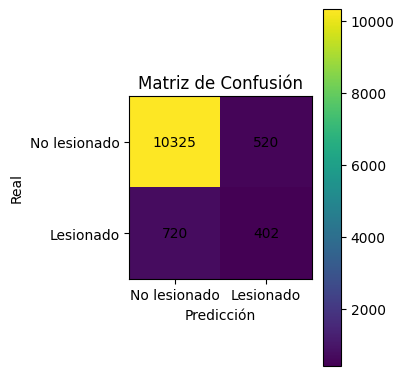

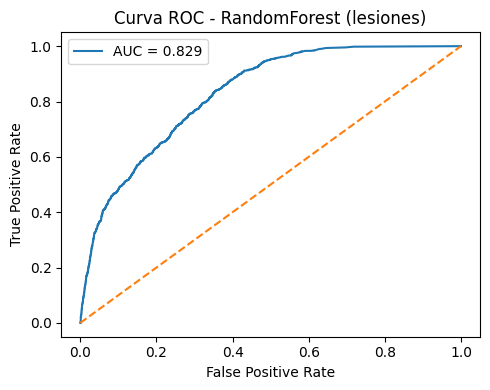

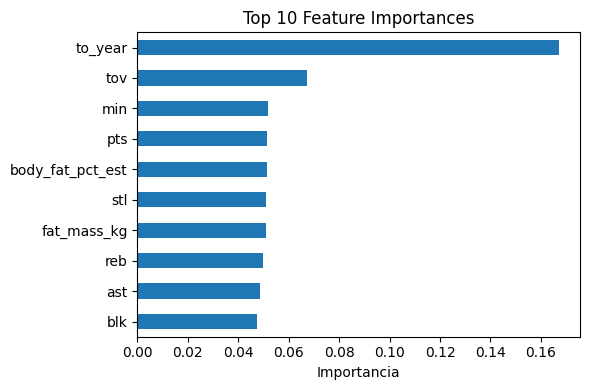

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, roc_curve

# Matriz de confusión
cm = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cm)
ax.set_title("Matriz de Confusión")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No lesionado","Lesionado"])
ax.set_yticklabels(["No lesionado","Lesionado"])
for (i, j), v in np.ndenumerate(cm):
    ax.text(j, i, int(v), ha="center", va="center")
plt.colorbar(im); plt.tight_layout(); plt.show()

# Curva ROC
fpr, tpr, thr = roc_curve(y_test, y_proba)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba):.3f}")
ax.plot([0,1],[0,1],"--")
ax.set_title("Curva ROC - RandomForest (lesiones)")
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.legend(); plt.tight_layout(); plt.show()

# Importancia de variables (Top 10)
importances = pd.Series(rf.feature_importances_, index=X_imputed.columns)
top10 = importances.sort_values(ascending=False).head(10)

fig, ax = plt.subplots(figsize=(6,4))
top10.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top 10 Feature Importances"); ax.set_xlabel("Importancia")
plt.tight_layout(); plt.show()


ANALISIS DE RESULTADOS DEL MODELO PREDICCION DE LESIONES

Para evaluar nuestro primer modelo de maching learning utilizamos  un RandomForestClassifier. Generando tres visualizaciones clave, la matriz de confusion, la curva ROC y el grafico de importancia de variables.
-En la primer visualizacion, la matriz de confusion, podemos observar que el modelo acierta en la mayoria de los casos no lesionados(los verdaderos negativos).Tambien identifica 402 casos reales de lesionados. Sin embargo, presenta 720 casos falsos negativos, es decir jugadores lesionados que no fueron detectados. Esto refleja una limitacion en el recall de la clase lesionado, influenciado por el fuerte desbalanceado entre clases.
-En la segunda visualizacion, la curva ROC, podemos observar que el AUC obtenido es de 0,829, lo que implica que el modelo tiene un 82% de capacidad para discriminar entre lesionados y no lesionados. Este numero es considerado bueno y demuestra que el modelo es capaz de capturar patrones relevantes en los datos.
-En la tercer visualizacion, Importancia de Variables, encontramos las variables que fueron mas relevantes para el modelo. En la que se destaca la ultima temporada de cada jugador, seguido por variables de cargas de juego y condicion fisica. Lo que confirma que el modelo toma todo tipo de variables a la hora depredecir lesiones.


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


Distribución train antes de SMOTE: [43379  4488]
Distribución train después de SMOTE: [43379 43379]
Umbral óptimo por F1 ≈ 0.343 | Prec=0.360 Rec=0.448 F1=0.399

ROC-AUC (SMOTE): 0.824

=== SMOTE (threshold=0.50) (threshold=0.50) ===
              precision    recall  f1-score   support

           0      0.936     0.942     0.939     10845
           1      0.402     0.375     0.388      1122

    accuracy                          0.889     11967
   macro avg      0.669     0.659     0.664     11967
weighted avg      0.886     0.889     0.887     11967

Matriz de confusión:
 [[10218   627]
 [  701   421]]

=== SMOTE (umbral optimizado) (threshold=0.34) ===
              precision    recall  f1-score   support

           0      0.941     0.918     0.929     10845
           1      0.360     0.448     0.399      1122

    accuracy                          0.874     11967
   macro avg      0.651     0.683     0.664     11967
weighted avg      0.887     0.874     0.880     11967

Matriz 

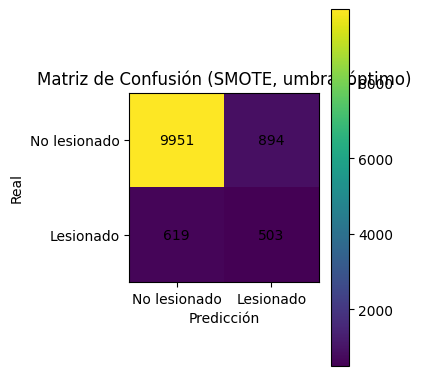

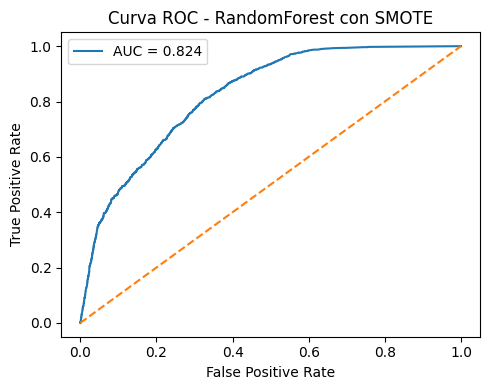

In [46]:
# =========================================================
# Oversampling con SMOTE + RandomForest + métricas y gráficos
# =========================================================

# 0) Instalar imbalanced-learn si hace falta
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    !pip install imbalanced-learn -q
    from imblearn.over_sampling import SMOTE

import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    classification_report, roc_auc_score, confusion_matrix,
    precision_recall_curve, roc_curve
)
import matplotlib.pyplot as plt

# -------------------------------
# 1) Preparar X/y si no existen
# -------------------------------
def build_features_from_master(df_master: pd.DataFrame):
    drop_cols = [c for c in ["injured","injury_count","player_id","season"] if c in df_master.columns]
    X0 = df_master.drop(columns=drop_cols).copy()
    y  = df_master["injured"].astype(int).copy()

    # One-hot de TODAS las categóricas
    obj_cols = X0.select_dtypes(include=["object"]).columns.tolist()
    X = pd.get_dummies(X0, columns=obj_cols, drop_first=True)

    # Forzar numérico y limpiar inf
    X = X.apply(pd.to_numeric, errors="coerce").replace([np.inf, -np.inf], np.nan)

    # Eliminar columnas completamente vacías
    all_nan_cols = X.columns[X.isna().all()].tolist()
    if all_nan_cols:
        print("Se eliminan columnas completamente vacías:", all_nan_cols)
        X = X.drop(columns=all_nan_cols)

    # Imputación mediana
    imp = SimpleImputer(strategy="median")
    X_imp = pd.DataFrame(imp.fit_transform(X), columns=X.columns, index=X.index)
    return X_imp, y

if 'X_train' not in globals() or 'y_train' not in globals():
    X_imputed, y = build_features_from_master(dataset_master)
    X_train, X_test, y_train, y_test = train_test_split(
        X_imputed, y, test_size=0.2, random_state=42, stratify=y
    )

print("Distribución train antes de SMOTE:", np.bincount(y_train))

# -------------------------------
# 2) SMOTE en el set de entrenamiento
# -------------------------------
sm = SMOTE(random_state=42, k_neighbors=5)
X_train_sm, y_train_sm = sm.fit_resample(X_train, y_train)

print("Distribución train después de SMOTE:", np.bincount(y_train_sm))

# -------------------------------
# 3) Entrenar modelo en datos balanceados
# -------------------------------
rf_sm = RandomForestClassifier(
    n_estimators=300,
    random_state=42,
    n_jobs=-1
)  # con SMOTE normalmente no usamos class_weight
rf_sm.fit(X_train_sm, y_train_sm)

# -------------------------------
# 4) Predicciones y umbral óptimo por F1 (clase 1)
# -------------------------------
y_proba_sm = rf_sm.predict_proba(X_test)[:, 1]
prec, rec, thr = precision_recall_curve(y_test, y_proba_sm)
f1 = 2 * (prec * rec) / np.where((prec + rec) == 0, 1, (prec + rec))
best_idx = np.nanargmax(f1[:-1])  # thr tiene len = len(prec)-1
best_thr = thr[best_idx]

def eval_with_threshold(y_true, y_scores, thr, title=""):
    y_hat = (y_scores >= thr).astype(int)
    print(f"\n=== {title} (threshold={thr:.2f}) ===")
    print(classification_report(y_true, y_hat, digits=3))
    cm = confusion_matrix(y_true, y_hat)
    print("Matriz de confusión:\n", cm)
    return y_hat, cm

print(f"Umbral óptimo por F1 ≈ {best_thr:.3f} | Prec={prec[best_idx]:.3f} Rec={rec[best_idx]:.3f} F1={f1[best_idx]:.3f}")
print("\nROC-AUC (SMOTE):", round(roc_auc_score(y_test, y_proba_sm), 3))

# Evaluación con threshold 0.50 y con umbral óptimo
y_pred50, cm50 = eval_with_threshold(y_test, y_proba_sm, 0.50, "SMOTE (threshold=0.50)")
y_predBest, cmBest = eval_with_threshold(y_test, y_proba_sm, best_thr, "SMOTE (umbral optimizado)")

# -------------------------------
# 5) Gráficos: Confusión y ROC
# -------------------------------

# Matriz de Confusión (umbral óptimo)
fig, ax = plt.subplots(figsize=(4,4))
im = ax.imshow(cmBest)
ax.set_title("Matriz de Confusión (SMOTE, umbral óptimo)")
ax.set_xlabel("Predicción"); ax.set_ylabel("Real")
ax.set_xticks([0,1]); ax.set_yticks([0,1])
ax.set_xticklabels(["No lesionado","Lesionado"])
ax.set_yticklabels(["No lesionado","Lesionado"])
for (i, j), v in np.ndenumerate(cmBest):
    ax.text(j, i, int(v), ha="center", va="center")
plt.colorbar(im); plt.tight_layout(); plt.show()

# Curva ROC
fpr, tpr, _ = roc_curve(y_test, y_proba_sm)
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(fpr, tpr, label=f"AUC = {roc_auc_score(y_test, y_proba_sm):.3f}")
ax.plot([0,1],[0,1],"--")
ax.set_title("Curva ROC - RandomForest con SMOTE")
ax.set_xlabel("False Positive Rate"); ax.set_ylabel("True Positive Rate")
ax.legend(); plt.tight_layout(); plt.show()


=== Métricas de Talento (Regresión) ===
MAE : 0.016
RMSE: 0.041
R²  : 0.995


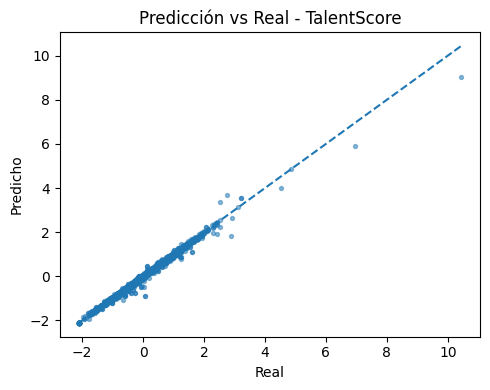

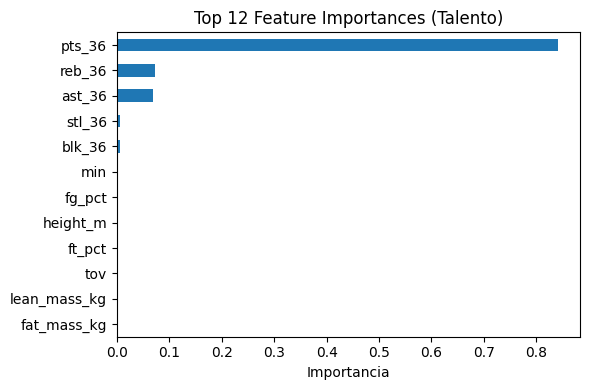


=== Top 20 talentos previstos ===


,player_id,season,position_std,TalentScore_pred,min
3421,0,<NA>,NaN,3.74,472.00
3492,0,<NA>,NaN,3.74,472.00
52852,203507,2023,Small Forward,2.89,1917.00
52853,203507,2024,Small Forward,2.89,1917.00
53761,203954,2019,Power Forward,2.81,1309.00
53760,203954,2018,Power Forward,2.81,1309.00
52859,203507,2030,Small Forward,2.73,2024.00
52858,203507,2029,Small Forward,2.73,2024.00
29379,76375,1980,Center,2.72,3882.00
29378,76375,1979,Center,2.72,3882.00


In [47]:
# ============================================
# MODELO ÚNICO DE TALENTO (ofensivo + defensivo + biometría)
# ============================================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

dm = dataset_master.copy()

# -------- Helpers
def per36(series, minutes):
    s = pd.to_numeric(series, errors="coerce")
    m = pd.to_numeric(minutes, errors="coerce")
    out = (s / m) * 36
    return out.replace([np.inf, -np.inf], np.nan)

# -------- Métricas por 36' (normaliza por tiempo en cancha)
dm["pts_36"] = per36(dm.get("pts"), dm.get("min"))
dm["ast_36"] = per36(dm.get("ast"), dm.get("min"))
dm["reb_36"] = per36(dm.get("reb"), dm.get("min"))
dm["stl_36"] = per36(dm.get("stl"), dm.get("min"))
dm["blk_36"] = per36(dm.get("blk"), dm.get("min"))

# -------- Índice compuesto de Talento (z-scores + pesos)
# Pesos: ofensivo ~70% (puntos+asistencias+rebotes), defensivo ~30% (robos+tapas)
from sklearn.preprocessing import StandardScaler
scaler_tmp = StandardScaler()

z_cols = ["pts_36","ast_36","reb_36","stl_36","blk_36"]
Z = pd.DataFrame(
    scaler_tmp.fit_transform(dm[z_cols]),
    columns=[f"z_{c}" for c in z_cols],
    index=dm.index
)
dm = pd.concat([dm, Z], axis=1)

dm["TalentScore"] = (
    0.50*dm["z_pts_36"] +   # más peso a conversión de puntos
    0.20*dm["z_ast_36"] +
    0.20*dm["z_reb_36"] +
    0.05*dm["z_stl_36"] +
    0.05*dm["z_blk_36"]
)

# -------- Features: biometría + % tiros + volumen + posición
candidate_feats = [
    # % tiro
    "fg_pct","fg3_pct","ft_pct",
    # volumen/uso
    "min","tov",
    # biometría
    "height_m","weight_kg","BMI","body_fat_pct_est","fat_mass_kg","lean_mass_kg",
    # posición (categoría)
    "position_std",
    # por 36'
    "pts_36","ast_36","reb_36","stl_36","blk_36"
]
features = [c for c in candidate_feats if c in dm.columns]

X = dm[features].copy()
y = dm["TalentScore"].copy()

# -------- Preprocesamiento
num_cols = X.select_dtypes(exclude=["object"]).columns.tolist()
cat_cols = X.select_dtypes(include=["object"]).columns.tolist()

pre = ColumnTransformer(
    transformers=[
        ("num", Pipeline([
            ("imp", SimpleImputer(strategy="median")),
            ("sc", StandardScaler())
        ]), num_cols),
        ("cat", Pipeline([
            ("imp", SimpleImputer(strategy="most_frequent")),
            ("oh", OneHotEncoder(handle_unknown="ignore"))
        ]), cat_cols)
    ],
    remainder="drop"
)

# -------- Modelo
rf = RandomForestRegressor(
    n_estimators=400,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)

pipe = Pipeline(steps=[("pre", pre), ("rf", rf)])

# -------- Train/Test
# (filtramos filas donde el target sea NaN)
mask = y.notna()
X_train, X_test, y_train, y_test = train_test_split(
    X[mask], y[mask], test_size=0.2, random_state=42
)

# -------- Entrenar
pipe.fit(X_train, y_train)

# -------- Evaluación
y_pred = pipe.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
rmse = mean_absolute_error(y_test, y_pred)**0.5  # MAE**0.5 NO es RMSE; calculamos bien abajo
rmse = np.sqrt(((y_test - y_pred)**2).mean())
r2 = r2_score(y_test, y_pred)

print("=== Métricas de Talento (Regresión) ===")
print(f"MAE : {mae:.3f}")
print(f"RMSE: {rmse:.3f}")
print(f"R²  : {r2:.3f}")

# -------- Gráfico 1: Predicho vs Real
fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(y_test, y_pred, s=8, alpha=0.5)
lims = [min(y_test.min(), y_pred.min()), max(y_test.max(), y_pred.max())]
ax.plot(lims, lims, "--")
ax.set_title("Predicción vs Real - TalentScore")
ax.set_xlabel("Real"); ax.set_ylabel("Predicho")
plt.tight_layout(); plt.show()

# -------- Importancias (Top 12)
# Obtenemos nombres de features después del OneHot
oh = pipe.named_steps["pre"].named_transformers_["cat"].named_steps["oh"]
cat_out = oh.get_feature_names_out(cat_cols) if cat_cols else np.array([])
num_out = np.array(num_cols)
final_cols = np.r_[num_out, cat_out]

importances = pipe.named_steps["rf"].feature_importances_
imp_ser = pd.Series(importances, index=final_cols).sort_values(ascending=False).head(12)

fig, ax = plt.subplots(figsize=(6,4))
imp_ser.sort_values().plot(kind="barh", ax=ax)
ax.set_title("Top 12 Feature Importances (Talento)")
ax.set_xlabel("Importancia")
plt.tight_layout(); plt.show()

# -------- Ranking (Top 20 talentos previstos)
# Reentrenamos en todo el set válido y predecimos sobre todo para rankear
pipe.fit(X[mask], y[mask])
dm_loc = dm.loc[mask, ["player_id","season"] + [c for c in ["player_name","position_std"] if c in dm.columns]].copy()
dm_loc["TalentScore_pred"] = pipe.predict(X[mask])

# opcional: filtrar jugadores con minutos razonables (evita ruido)
min_cut = 200  # jugá con este umbral
if "min" in dm.columns:
    dm_loc = dm_loc.join(dm["min"], how="left")
    dm_loc = dm_loc[dm_loc["min"] >= min_cut]

top20 = dm_loc.sort_values("TalentScore_pred", ascending=False).head(20)
print("\n=== Top 20 talentos previstos ===")
display(top20)


GUARDAMOS AMBOS MODELOS COMO PIPELINES

In [48]:
# 1A) Lesiones (clasificación) -> models/injury_rf.joblib
import os, joblib
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

y = dataset_master["injured"].astype(int)
X0 = dataset_master.drop(columns=[c for c in ["injured","injury_count","player_id","season"] if c in dataset_master.columns])

num_cols = X0.select_dtypes(exclude=["object"]).columns.tolist()
cat_cols = X0.select_dtypes(include=["object"]).columns.tolist()

pre = ColumnTransformer([
    ("num", SimpleImputer(strategy="median"), num_cols),
    ("cat", Pipeline([("imp", SimpleImputer(strategy="most_frequent")),
                      ("oh", OneHotEncoder(handle_unknown="ignore"))]), cat_cols)
])

pipe_injury = Pipeline([
    ("pre", pre),
    ("rf", RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1, class_weight="balanced"))
])

X_train, X_test, y_train, y_test = train_test_split(X0, y, test_size=0.2, random_state=42, stratify=y)
pipe_injury.fit(X_train, y_train)

os.makedirs("models", exist_ok=True)
joblib.dump(pipe_injury, "models/injury_rf.joblib")
print("OK -> models/injury_rf.joblib")


OK -> models/injury_rf.joblib


In [49]:
# 1B) Talento (regresión) -> models/talent_rf.joblib
import os, joblib
os.makedirs("models", exist_ok=True)
joblib.dump(pipe, "models/talent_rf.joblib")  # 'pipe' es tu Pipeline del modelo de talento
print("OK -> models/talent_rf.joblib")


OK -> models/talent_rf.joblib


In [50]:

cols_demo = [c for c in [
    "player_id","player_name","season","position_std","min",
    "pts","reb","ast","stl","blk","tov","fg_pct","fg3_pct","ft_pct",
    "height_m","weight_kg","BMI","body_fat_pct_est","lean_mass_kg","fat_mass_kg",
    "injured"  # si existe
] if c in dataset_master.columns]

demo_master = dataset_master[cols_demo].dropna(subset=["min","pts"]).sample(min(3000, len(dataset_master)), random_state=42)

os.makedirs("data", exist_ok=True)
demo_master.to_csv("data/demo_master.csv", index=False)
print("OK -> data/demo_master.csv")


OK -> data/demo_master.csv


In [51]:


# aseguramos que la carpeta exista
os.makedirs("data", exist_ok=True)

# exportamos todas las tablas limpias
dim_player.to_csv("data/dim_player.csv", index=False)
fact_injuries.to_csv("data/fact_injuries.csv", index=False)
fact_player_stats.to_csv("data/fact_player_stats.csv", index=False)
fact_combine.to_csv("data/fact_combine.csv", index=False)
dim_injury_category.to_csv("data/dim_injury_category.csv", index=False)

print("✅ Tablas limpias exportadas en la carpeta 'data/'")


✅ Tablas limpias exportadas en la carpeta 'data/'
